<a href="https://colab.research.google.com/github/SamiraAsadzadeh/HomeWork_DeepLearning/blob/main/HomeWork_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **By: Samira Asadzadeh  40116341054541**

*   **Advisor:  Dr. Mr.Asadi**

*  **ISLAMIC AZAD UNIVERSITY SHIRAZ BRANCH Faculty of engineering**



# **Segmentation With U-Net**

https://deepthon.com/%D8%A2%D9%85%D9%88%D8%B2%D8%B4-%D8%A7%D9%84%DA%AF%D9%88%D8%B1%DB%8C%D8%AA%D9%85-u-net-%D8%A8%D8%A7-%DA%A9%D8%B1%D8%A7%D8%B3/

#Import Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# DataSet
استفاده از مجموعه داده های حیوانات خانگی Oxford-IIIT

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0VY8GV/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0VY8GV/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


# تغییر در اندازه ی تصاویر و ماسک ها
ابتدا اندازه تصاویر و ماسک ها را به  تغییر می دهیم به 28*28

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

# ایجاد یک تابع برای تقویت مجموعه داده

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
   # Random flipping of the image and mask
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

# ایجاد یک تابع برای نرمالیزه کردن مجموعه داده با مقیاس بندی تصاویر به محدوده [-1, 1]و کاهش ماسک تصویر به وسیله

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

### Data preprocessing

# ما دو تابع را برای پیش پردازش مجموعه داده های آموزشی  و آزمایشی  ایجاد می کنیم که تفاوت جزئی بین این دو وجود دارد.

ما فقط روی مجموعه داده آموزشی تقویت تصویر را انجام می دهیم.

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

Create train, validation and test batches. Note we split the original `test_dataset` into validation and test batches.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

### Data Visualization

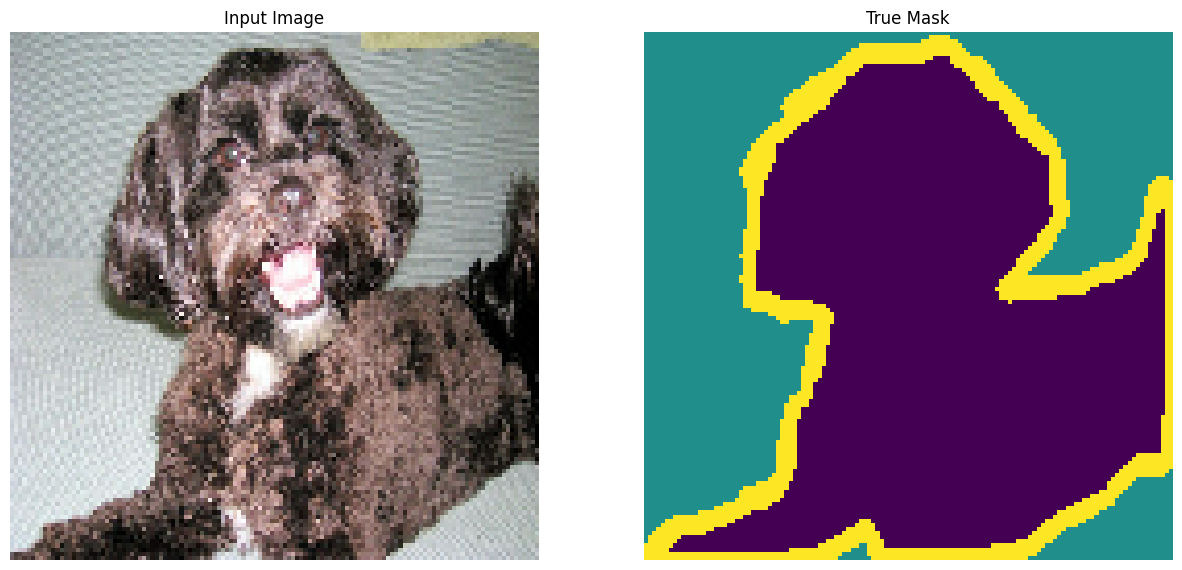

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

# Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
# Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
# upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
# concatenate
   x = layers.concatenate([x, conv_features])
# dropout
   x = layers.Dropout(0.3)(x)
# Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
# inputs
inputs = layers.Input(shape=(128,128,3))

# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(inputs, 64)
# 2 - downsample
f2, p2 = downsample_block(p1, 128)
# 3 - downsample
f3, p3 = downsample_block(p2, 256)
# 4 - downsample
f4, p4 = downsample_block(p3, 512)

# 5 - bottleneck
bottleneck = double_conv_block(p4, 1024)

# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 512)
# 7 - upsample
u7 = upsample_block(u6, f3, 256)
# 8 - upsample
u8 = upsample_block(u7, f2, 128)
# 9 - upsample
u9 = upsample_block(u8, f1, 64)

# outputs
outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

# unet model with Keras Functional API
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

#return unet_model

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")


In [ ]:
#We train the unet_model by calling model.fit() and training it for 20 epochs.

NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 118s 1s/step - loss: 0.9047 - accuracy: 0.5827 - val_loss: 0.8402 - val_accuracy: 0.6061
Epoch 2/20
57/57 [==============================] - 82s 1s/step - loss: 0.7543 - accuracy: 0.6637 - val_loss: 0.6521 - val_accuracy: 0.7440
Epoch 3/20
57/57 [==============================] - 69s 1s/step - loss: 0.6328 - accuracy: 0.7455 - val_loss: 0.5908 - val_accuracy: 0.7653
Epoch 4/20
57/57 [==============================] - 69s 1s/step - loss: 0.5736 - accuracy: 0.7716 - val_loss: 0.5302 - val_accuracy: 0.7963
Epoch 5/20
57/57 [==============================] - 69s 1s/step - loss: 0.5170 - accuracy: 0.7971 - val_loss: 0.4764 - val_accuracy: 0.8145
Epoch 6/20
57/57 [==============================] - 69s 1s/step - loss: 0.4662 - accuracy: 0.8189 - val_loss: 0.4455 - val_accuracy: 0.8282
Epoch 7/20
57/57 [==============================] - 69s 1s/step - loss: 0.4498 - accuracy: 0.8260 - val_loss: 0.4136 - val_accuracy: 0.8415
Epoch 8/20
57/57 [=

In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

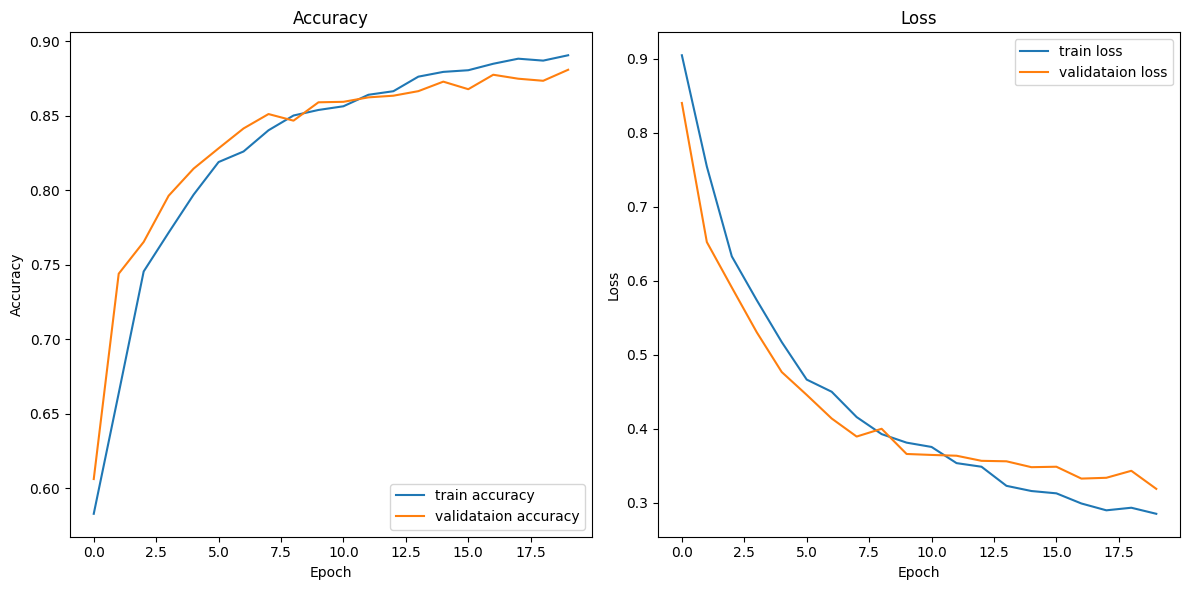

In [ ]:
# Display learning curves
display_learning_curves(unet_model.history)

## Predictions with U-Net model
Let's try the trained U-Net model on a few samples from the test dataset.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 1s 10ms/step


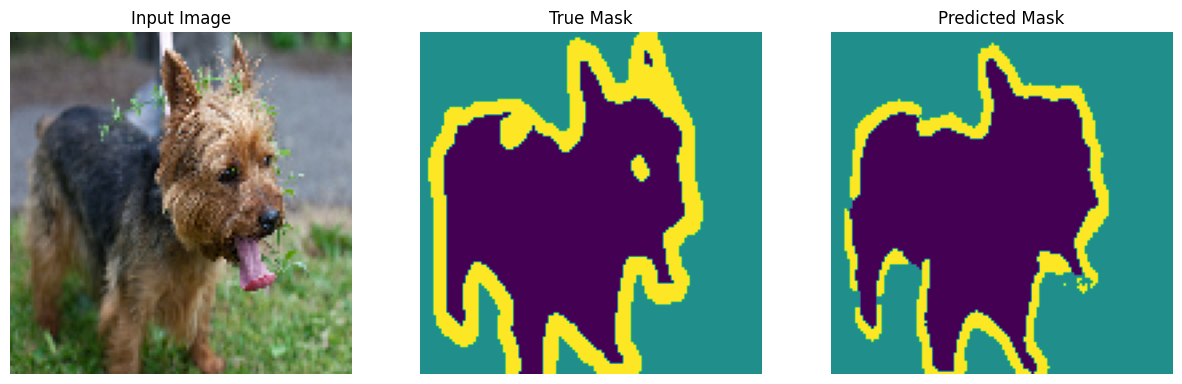

2/2 [==============================] - 0s 117ms/step


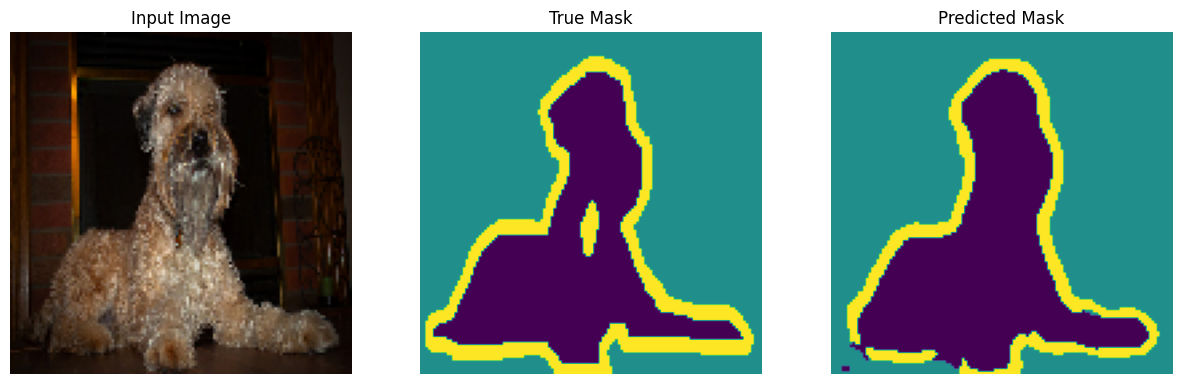

2/2 [==============================] - 0s 112ms/step


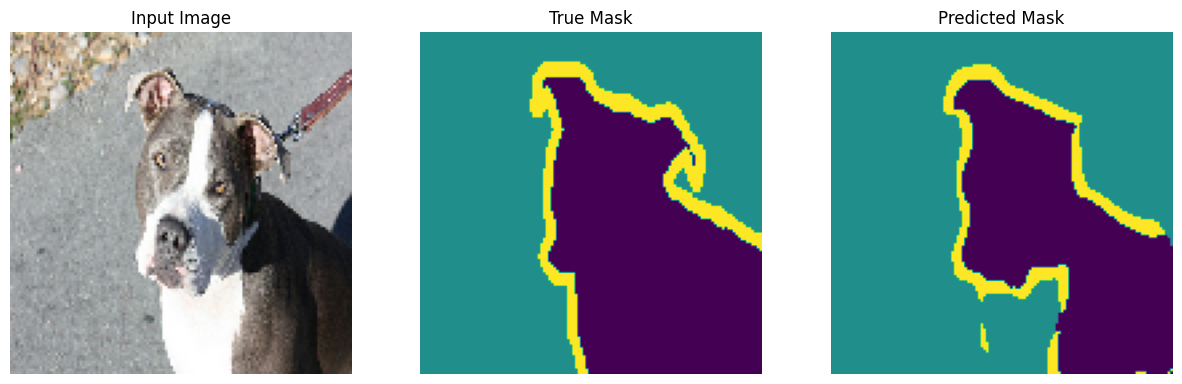

In [ ]:
show_predictions(test_batches.skip(5), 3)